In [1]:
# Import potential libraries to use

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller
from numpy import log

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
model_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/modelling_data.csv")
model_df.head()

,date,UV000005502,UV000005507,UV000005522,UV000065501,UV000065516,UVM00065503,UVM00065510,UVM00065518,IV000005557,...,SGM00061695,SGM00061697,SGM00061698,SGM00061699,SL000061856,LIM00065660,GHM00065472,CVM00008594,GV000001832,avg_temp
0,1980-01-01,23.89,24.44,26.67,21.67,24.44,23.33,24.44,26.67,25.56,...,23.33,26.67,28.89,30.00,26.67,27.78,26.11,21.67,26.11,24.630000
1,1980-01-02,24.44,24.44,27.22,24.44,26.11,25.00,26.11,26.67,25.56,...,24.44,26.67,27.78,26.11,26.67,27.78,28.89,22.22,26.11,25.208750
2,1980-01-03,24.44,25.00,26.11,22.78,25.00,25.56,25.00,26.67,26.11,...,23.33,26.67,28.89,27.78,26.67,27.78,28.89,21.11,26.11,25.409583
3,1980-01-04,23.33,25.00,26.11,23.33,24.44,24.44,25.00,26.67,26.67,...,21.67,26.67,23.33,28.33,26.67,27.78,28.89,21.67,26.11,25.547778
4,1980-01-05,23.89,25.56,27.22,23.89,25.56,25.56,26.67,26.67,26.11,...,24.44,26.67,23.33,27.22,26.67,27.78,28.89,21.67,26.11,25.339583


In [ ]:
# Convert the date to datetime

model_df["date"] = pd.to_datetime(model_df["date"], errors='coerce')

model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15706 entries, 0 to 15705
Data columns (total 74 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         15706 non-null  datetime64[ns]
 1   UV000005502  15706 non-null  float64       
 2   UV000005507  15706 non-null  float64       
 3   UV000005522  15706 non-null  float64       
 4   UV000065501  15706 non-null  float64       
 5   UV000065516  15706 non-null  float64       
 6   UVM00065503  15706 non-null  float64       
 7   UVM00065510  15706 non-null  float64       
 8   UVM00065518  15706 non-null  float64       
 9   IV000005557  15706 non-null  float64       
 10  IV000005562  15706 non-null  float64       
 11  IV000005592  15706 non-null  float64       
 12  IV000065585  15706 non-null  float64       
 13  IV000065599  15706 non-null  float64       
 14  IVM00065545  15706 non-null  float64       
 15  IVM00065560  15706 non-null  float64       
 16  IVM0

Creating a model with one of the stations

In [ ]:
y = model_df[['date', 'UV000005502']]
y.head()

,date,UV000005502
0,1980-01-01,23.89
1,1980-01-02,24.44
2,1980-01-03,24.44
3,1980-01-04,23.33
4,1980-01-05,23.89


In [ ]:
y = y.set_index('date')
y.head()

,UV000005502
date,
1980-01-01,23.89
1980-01-02,24.44
1980-01-03,24.44
1980-01-04,23.33
1980-01-05,23.89


In [ ]:
y = y.squeeze()
y.head()

date
1980-01-01    23.89
1980-01-02    24.44
1980-01-03    24.44
1980-01-04    23.33
1980-01-05    23.89
Name: UV000005502, dtype: float64

<Axes: xlabel='date'>

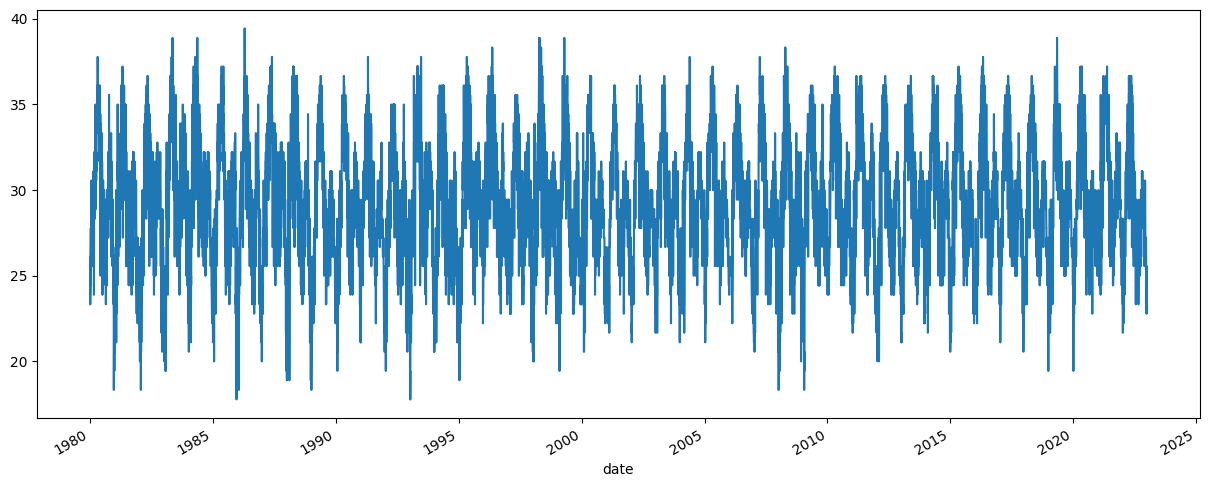

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

y.plot(ax=ax)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

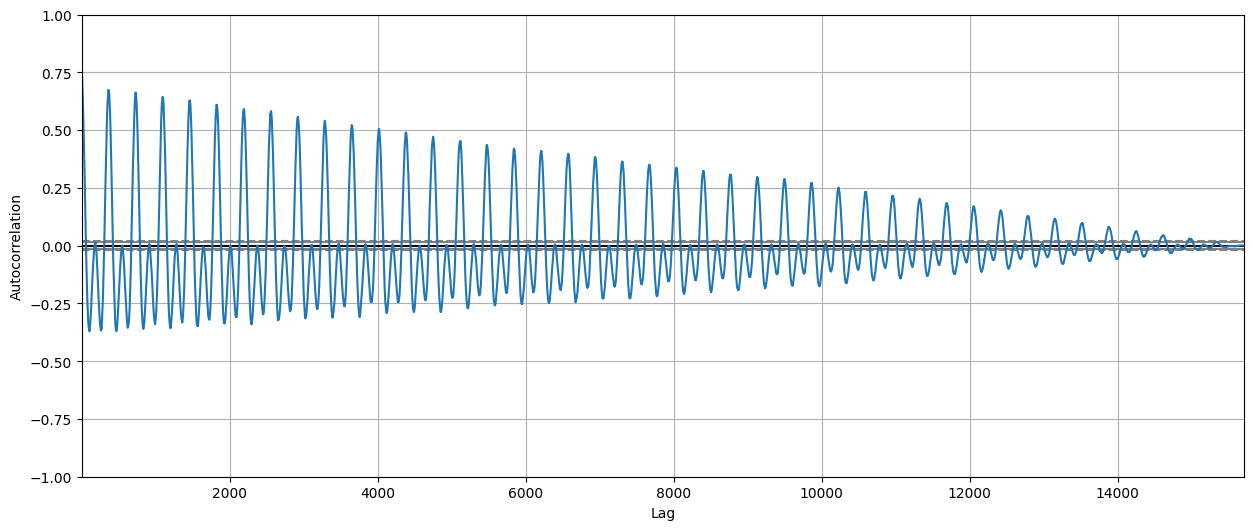

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

autocorrelation_plot(y)

In [ ]:
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.608482
p-value: 0.000000


Since p-value(0.00) is less than the significance level (p_value = 0.05) then we reject the null hypothesis and infer that the time series is indeed stationary. The null hypothesis (Ho) of the ADF test is that the time series is non-stationary.

So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.

If P Value > 0.05 we go ahead with finding the order of differencing.

#### Train Test Split

Splitting the data with 90% training set

In [ ]:
cutoff_test = int(len(y) * 0.90)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Total dataset", len(y_train + y_test))

y_train shape: (14135,)
y_test shape: (1571,)
Total dataset 15706


#### Baseline Model

In [ ]:
start_time = time.time()

y_train_mean = y_train.mean()

# Calculate model training time
elapsed_time = round(time.time() - start_time, 2)
print(f"Tested baseline model in {elapsed_time} seconds.")

y_pred_baseline = [y_train_mean] * len(y_train)

mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_train, y_pred_baseline))

print("Mean Temperatrure Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))
print("Root Mean Squared Error: ", round(rmse_baseline, 2))

Tested baseline model in 0.0 seconds.
Mean Temperatrure Reading: 29.19
Baseline MAE: 2.89
Root Mean Squared Error:  3.55


#### ARIMA Model

In [ ]:
# Note start time
start_time = time.time()
# Train model
model = ARIMA(y_train, order= (24,0,2)).fit()
# Calculate model training time
elapsed_time = round(time.time() - start_time, 2)
print(f"Trained ARIMA in {elapsed_time} seconds.")

y_pred = model.predict()

# Calculate training MAE
mae = mean_absolute_error(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("Mean Absolute Error: ", round(mae, 2))
print("Root Mean Squared Error: ", round(rmse, 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA in 468.04 seconds.
Mean Absolute Error:  1.19
Root Mean Squared Error:  1.59


In [ ]:
# Note start time
start_time = time.time()
# Train model
model_test = ARIMA(y_test, order= (24,0,2)).fit()
# Calculate model training time
elapsed_time = round(time.time() - start_time, 2)
print(f"Trained ARIMA in {elapsed_time} seconds for the test data.")

y_pred_test = model_test.predict()

# Calculate training MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Mean Absolute Error: ", round(mae_test, 2))
print("Root Mean Squared Error: ", round(rmse_test, 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA in 73.27 seconds for the test data.
Mean Absolute Error:  1.05
Root Mean Squared Error:  1.4


In [ ]:
y_test

date
2018-09-13    27.22
2018-09-14    27.22
2018-09-15    27.22
2018-09-16    27.22
2018-09-17    27.22
              ...  
2022-12-27    25.00
2022-12-28    25.56
2022-12-29    25.00
2022-12-30    25.00
2022-12-31    24.44
Name: UV000005502, Length: 1571, dtype: float64

In [ ]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

df_pred_test

,y_test,y_pred
date,,
2018-09-13,27.22,29.361122
2018-09-14,27.22,27.456332
2018-09-15,27.22,27.416109
2018-09-16,27.22,27.379443
2018-09-17,27.22,27.357634
...,...,...
2022-12-27,25.00,23.892983
2022-12-28,25.56,25.428983
2022-12-29,25.00,25.589516


In [ ]:
fig = px.line(df_pred_test, labels={"value": "Air Temp."})
fig.show()

### Facebook Prophet

In [ ]:
train_prophet = y_train.reset_index().rename(columns={'date':'ds', 'UV000005502':'y'})

train_prophet

,ds,y
0,1980-01-01,23.89
1,1980-01-02,24.44
2,1980-01-03,24.44
3,1980-01-04,23.33
4,1980-01-05,23.89
...,...,...
14130,2018-09-08,25.00
14131,2018-09-09,25.00
14132,2018-09-10,25.00
14133,2018-09-11,27.22


In [ ]:
from prophet import Prophet

train_prophet = y_train.reset_index().rename(columns={'date':'ds', 'UV000005502':'y'})

# Note start time
start_time = time.time()
# Train model
model = Prophet()
model.fit(train_prophet)
# Calculate model training time
elapsed_time = round(time.time() - start_time, 2)
print(f"Trained fbProphet in {elapsed_time} seconds.")

train_forecast = model.predict(train_prophet)

# Calculate training MAE
mae = mean_absolute_error(y_true = train_prophet['y'], y_pred = train_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(y_true = train_prophet['y'], y_pred = train_forecast['yhat']))

print("Mean Absolute Error: ", round(mae, 2))
print("Root Mean Squared Error: ", round(rmse, 2))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwojgf6i2/rjx05uhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwojgf6i2/gpqtezwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11086', 'data', 'file=/tmp/tmpwojgf6i2/rjx05uhu.json', 'init=/tmp/tmpwojgf6i2/gpqtezwd.json', 'output', 'file=/tmp/tmpwojgf6i2/prophet_modelj9arg190/prophet_model-20231214185214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Trained fbProphet in 13.28 seconds.
Mean Absolute Error:  1.53
Root Mean Squared Error:  1.96


In [ ]:
test_prophet = y_test.reset_index().rename(columns={'date':'ds', 'UV000005502':'y'})

# Note start time
start_time = time.time()
# Train model
model = Prophet()
model.fit(train_prophet)
# Calculate model training time
elapsed_time = round(time.time() - start_time, 2)
print(f"Tested fbProphet in {elapsed_time} seconds.")

test_forecast = model.predict(test_prophet)

# Calculate training MAE
mae = mean_absolute_error(y_true = test_prophet['y'], y_pred = test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(y_true = test_prophet['y'], y_pred = test_forecast['yhat']))

print("Mean Absolute Error: ", round(mae, 2))
print("Root Mean Squared Error: ", round(rmse, 2))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwojgf6i2/ph_3yozo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwojgf6i2/5valgwpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83485', 'data', 'file=/tmp/tmpwojgf6i2/ph_3yozo.json', 'init=/tmp/tmpwojgf6i2/5valgwpj.json', 'output', 'file=/tmp/tmpwojgf6i2/prophet_modelulztbf39/prophet_model-20231214190714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Tested fbProphet in 7.56 seconds.
Mean Absolute Error:  1.42
Root Mean Squared Error:  1.8


In [ ]:
test_prophet['y']

0       27.22
1       27.22
2       27.22
3       27.22
4       27.22
        ...  
1566    25.00
1567    25.56
1568    25.00
1569    25.00
1570    24.44
Name: y, Length: 1571, dtype: float64

In [ ]:
df_pred_test = pd.concat([test_prophet['y'], test_forecast['yhat']], axis = 1)

df_pred_test.columns = ['y_test', 'y_pred']

df_pred_test.index = test_forecast['ds']

df_pred_test

,y_test,y_pred
ds,,
2018-09-13,27.22,27.735917
2018-09-14,27.22,27.760442
2018-09-15,27.22,27.828146
2018-09-16,27.22,27.926969
2018-09-17,27.22,28.017347
...,...,...
2022-12-27,25.00,24.411286
2022-12-28,25.56,24.232600
2022-12-29,25.00,24.201573


In [ ]:
fig = px.line(df_pred_test, labels={"value": "Air Temp."})
fig.show()

In [ ]:
train_var.set_index('date')

,UV000005502
date,
1980-01-01,23.89
1980-01-02,24.44
1980-01-03,24.44
1980-01-04,23.33
1980-01-05,23.89
...,...
2018-09-08,25.00
2018-09-09,25.00
2018-09-10,25.00


### VAR Model

In [ ]:
y_var = y = model_df[['date', 'UV000005502', 'UV000005507']]

cutoff_test = int(len(y) * 0.90)
y_var_train = y.iloc[:cutoff_test]
y_var_test = y.iloc[cutoff_test:]

In [ ]:
from statsmodels.tsa.api import VAR

train_var = y_var_train.set_index('date')

start_time = time.time()
model = VAR(train_var)
results = model.fit(maxlags=4, ic='aic')
# maxlags is the maximum lag order, ic='aic' tells the model to use Akaike Information Criterion to select the best lag value

elapsed_time = round(time.time() - start_time, 2)
print(f"Tested fbProphet in {elapsed_time} seconds.")

predictions = results.forecast(train_var.values[-results.k_ar:], steps=len(train_var))

pred_df = pd.DataFrame(predictions, index= y_train.index)

pred_df.columns = ['UV000005502', 'UV000005507']

# Calculate training MAE
mae = mean_absolute_error(y_true = y_var_train['UV000005502'], y_pred = pred_df['UV000005502'])
rmse = np.sqrt(mean_squared_error(y_true = y_var_train['UV000005502'], y_pred = pred_df['UV000005502']))

print("Mean Absolute Error: ", round(mae, 2))
print("Root Mean Squared Error: ", round(rmse, 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tested fbProphet in 0.51 seconds.
Mean Absolute Error:  2.88
Root Mean Squared Error:  3.54


In [ ]:
from statsmodels.tsa.api import VAR

test_var = y_var_test.set_index('date')

start_time = time.time()
model = VAR(test_var)
results = model.fit(maxlags=4, ic='aic')
# maxlags is the maximum lag order, ic='aic' tells the model to use Akaike Information Criterion to select the best lag value

elapsed_time = round(time.time() - start_time, 2)
print(f"Tested fbProphet in {elapsed_time} seconds.")

predictions = results.forecast(test_var.values[-results.k_ar:], steps=len(test_var))

pred_df = pd.DataFrame(predictions, index= y_test.index)

pred_df.columns = ['UV000005502', 'UV000005507']

# Calculate training MAE
mae = mean_absolute_error(y_true = y_var_test['UV000005502'], y_pred = pred_df['UV000005502'])
rmse = np.sqrt(mean_squared_error(y_true = y_var_test['UV000005502'], y_pred = pred_df['UV000005502']))

print("Mean Absolute Error: ", round(mae, 2))
print("Root Mean Squared Error: ", round(rmse, 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tested fbProphet in 0.11 seconds.
Mean Absolute Error:  2.81
Root Mean Squared Error:  3.42


In [ ]:
y_var_test['UV000005502'].index = pred_df.index

In [ ]:
y_var_test['UV000005502']

date
2018-09-13    27.22
2018-09-14    27.22
2018-09-15    27.22
2018-09-16    27.22
2018-09-17    27.22
              ...  
2022-12-27    25.00
2022-12-28    25.56
2022-12-29    25.00
2022-12-30    25.00
2022-12-31    24.44
Name: UV000005502, Length: 1571, dtype: float64

In [ ]:
df_pred_test = pd.concat([y_var_test['UV000005502'], pred_df['UV000005502']], axis = 1)

df_pred_test.columns = ['y_test', 'y_pred']

df_pred_test

,y_test,y_pred
date,,
2018-09-13,27.22,24.632455
2018-09-14,27.22,24.914616
2018-09-15,27.22,24.970834
2018-09-16,27.22,25.010857
2018-09-17,27.22,25.077110
...,...,...
2022-12-27,25.00,29.326138
2022-12-28,25.56,29.326138
2022-12-29,25.00,29.326138


In [ ]:
fig = px.line(df_pred_test, labels={"value": "Air Temp."})
fig.show()